In [33]:
#Imports
import numpy as np
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import matplotlib.pyplot as plt

In [34]:
#faz conexão com a cena
try:
    client = RemoteAPIClient()
    sim = client.require('sim')
except:
    print('Error connection')

In [35]:
#----------------Realiza a leitura do Laser---------------------------
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):
    
    signalName = sim.waitForSignal(range_data_signal_id)
    
    string_range_data = sim.getStringSignal(range_data_signal_id)

    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # verifique se ambos os dados foram obtidos corretamente
    if string_range_data != None and string_angle_data != None:
        # descompacte dados de mensagens de alcance e sensor
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data

    # retornar nenhum caso nada tenha sido obtido do simulador
    return None

def draw_laser_data(laser_data, transformationMatrix, origin, graph_title):
    
    fig = plt.figure(figsize=(6,6), dpi=100) #cria figura
    plt.title(graph_title)
    ax = fig.add_subplot(111, aspect='equal') #adiciona um subplot a figura
    max_sensor_range=5
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i] #pega os valores de angulo e distância

        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang) #meu x
            y = dist * np.sin(ang) #meu y
            point = np.array([x,y,0])
            point = transformationMatrix @ point

            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot(point[0], point[1], 'o', color=c) #plota o ponto

    ax.plot(origin[0], origin[1], 'k>', markersize=10) #A origem é a posição atual do robô
        
    ax.grid() #adiciona uma grade ao gráfico
    ax.set_xlim([-max_sensor_range, max_sensor_range]) #define os limites do eixo x
    ax.set_ylim([-max_sensor_range, max_sensor_range]) #define os limites eixo y

def processes_laser_data(matriz = np.array([]), origin_RP = np.array([0,0]), graph_title=''):
    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"

    raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    draw_laser_data(laser_data, matriz, origin_RP, graph_title)

In [36]:
# ------------------ Funções auxiliares - Plotar posição do robô e plotar os objetos no caminho do robô ----------------
def plot_robot_path(pos):
    plt.plot(pos[0], pos[1], 'o', color = 'g')

def plot_objects_robot_path(points_objects, angles_objects):
    for point, angle in zip(points_objects, angles_objects):
        c = 'r'
        if angle < 0:    
            c = 'b'
        plt.plot(point[0], point[1], 'o', color=c)

In [37]:
# --------------- Funções auxiliares - Tranformação de Matriz, plot Sistema de Coordenadas e Muda de posição Robô -----------------
def get_rotation_matrix(thetaZ):
    return np.array([[  np.cos(thetaZ), -np.sin(thetaZ), 0 ],
                      [ np.sin(thetaZ),  np.cos(thetaZ), 0 ],
                      [ 0            ,  0            , 1 ]])

In [38]:
def get_Transformation_matrix_Laser_World():
    objectHandle_RP = sim.getObject("/" + "Pioneer_p3dx")

    objectHandle_Laser = sim.getObject("/" + "fastHokuyo")
    eulerAngles_Laser = sim.getObjectOrientation(objectHandle_Laser, 
                                                objectHandle_RP)

    #Matriz de Rotação Laser -> Robô
    rotationMatrix_Laser = get_rotation_matrix(eulerAngles_Laser[2])

    #Matriz de Rotação Robô -> mundo
    eulerAngles_RP = sim.getObjectOrientation(objectHandle_RP, 
                                                sim.handle_world)
    rotationMatrix_RP = get_rotation_matrix(eulerAngles_RP[2])
    #Matriz de Transformação Laser -> Mundo
    return rotationMatrix_Laser @ rotationMatrix_RP

In [39]:
#Realiza o calculo da força de atração 
def att_force(q, goal, k=2):
    f = k*(np.array(goal) - np.array(q))
    return f

#Realiza o calculo da força de repulsão
def rep_force(q, obs, p=1, krep=.1):
    rep = 0
    #passa por todos os pontos retornados pelo laser
    v = np.array(q) - np.array(obs[0:2])
    d = np.linalg.norm(v) - obs[2]# Calcula a distância entre o robô e o obstáculo

    # Calcula a força de repulsão apenas se a distância for menor que p
    if (d < p):  
        rep = (1/d**2)*((1/d)-(1/p))*(v/d)

    return np.array(krep)*np.array(rep)

Matriz de transformação =  [[ 0.99999871  0.00160414  0.        ]
 [-0.00160414  0.99999871  0.        ]
 [ 0.          0.          1.        ]]
Ponto =  [-5.77238770e-08 -1.32056832e+00  2.88661721e-01]
Matriz de transformação =  [[ 0.99999871  0.00160414  0.        ]
 [-0.00160414  0.99999871  0.        ]
 [ 0.          0.          1.        ]]
Ponto =  [ 0.00388795 -1.32188547  0.28866172]
Matriz de transformação =  [[ 0.99999871  0.00160414  0.        ]
 [-0.00160414  0.99999871  0.        ]
 [ 0.          0.          1.        ]]
Ponto =  [ 0.00777578 -1.31799753  0.28866172]
Matriz de transformação =  [[ 0.99999871  0.00160414  0.        ]
 [-0.00160414  0.99999871  0.        ]
 [ 0.          0.          1.        ]]
Ponto =  [ 0.01170993 -1.31930984  0.28866172]
Matriz de transformação =  [[ 0.99999871  0.00160414  0.        ]
 [-0.00160414  0.99999871  0.        ]
 [ 0.          0.          1.        ]]
Ponto =  [ 0.0156752  -1.32063242  0.28866172]
Matriz de transformação =  [

KeyboardInterrupt: 

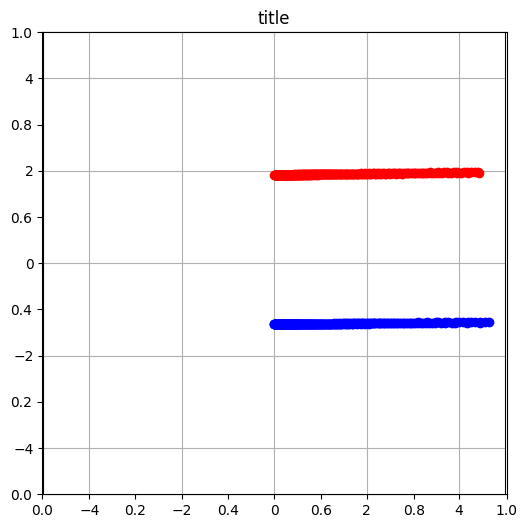

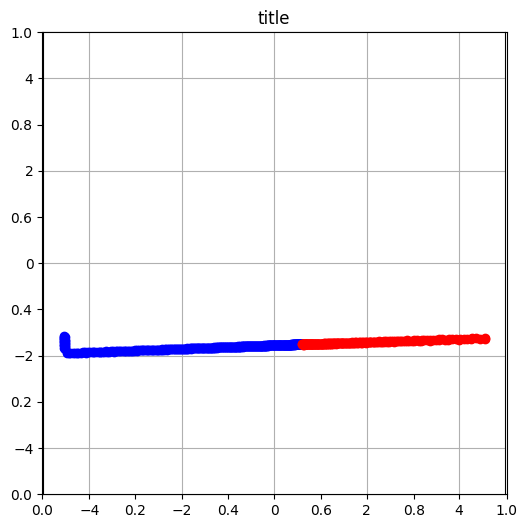

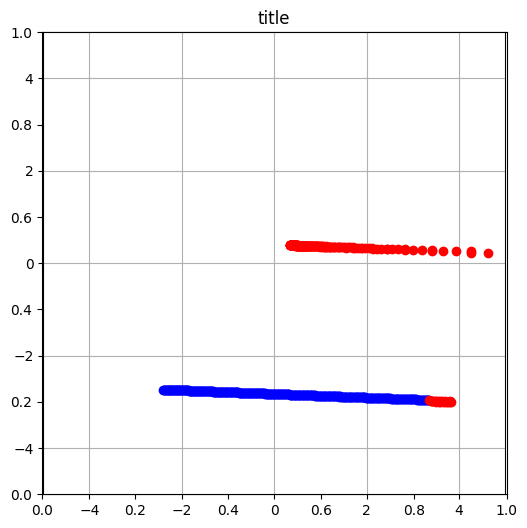

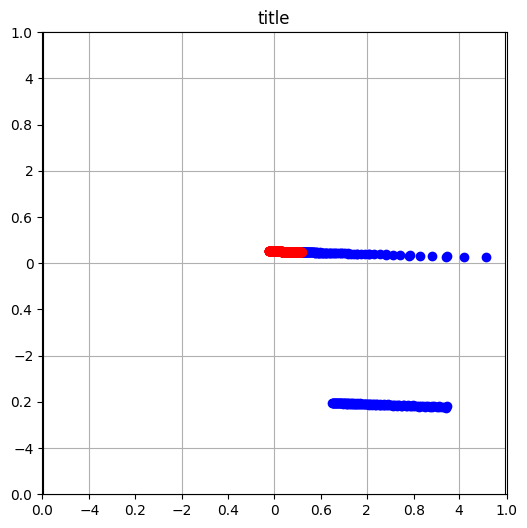

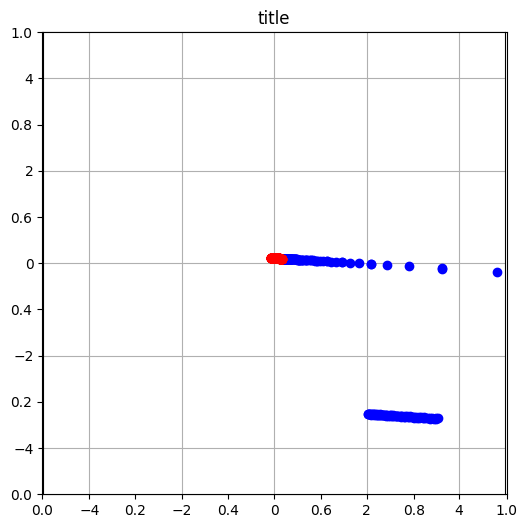

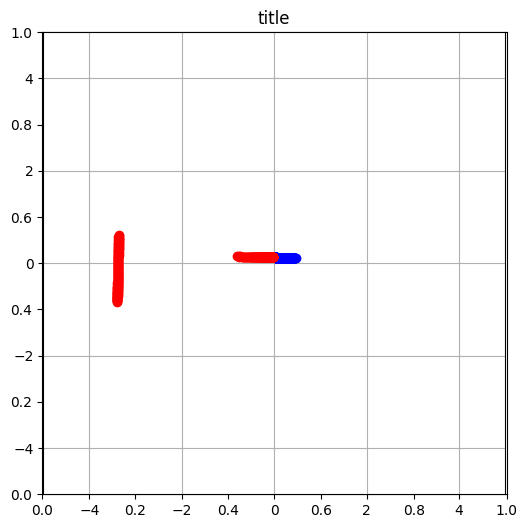

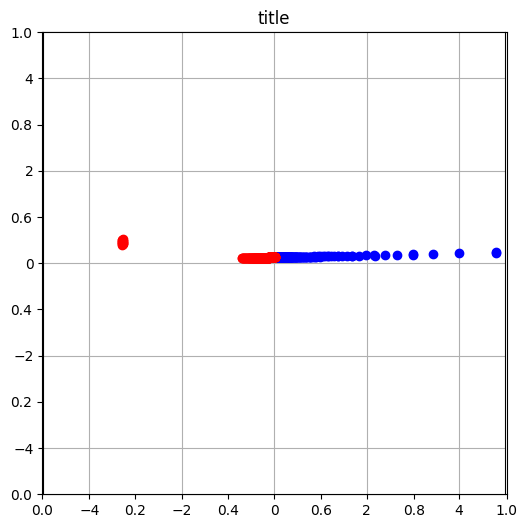

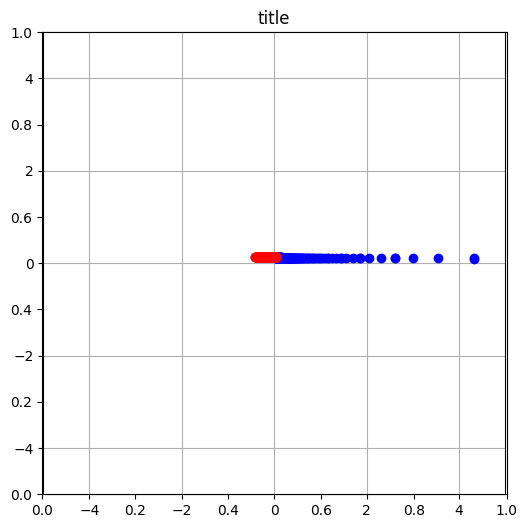

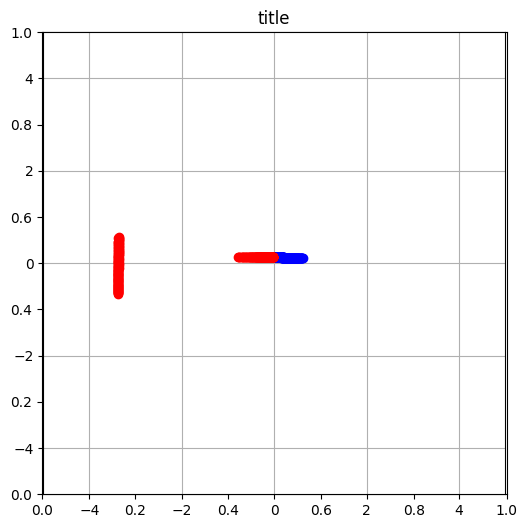

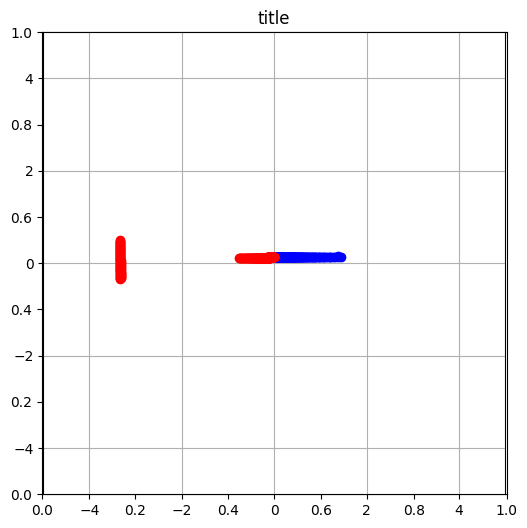

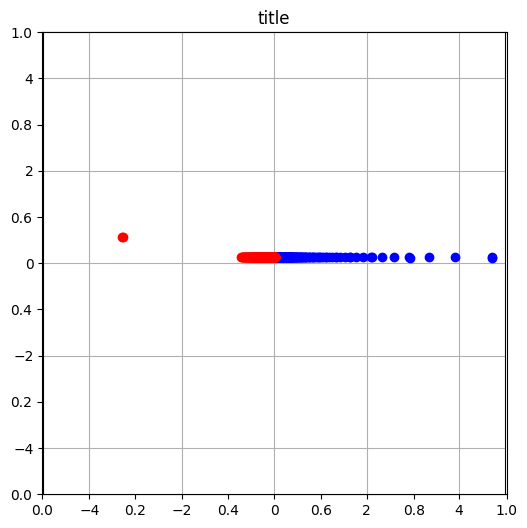

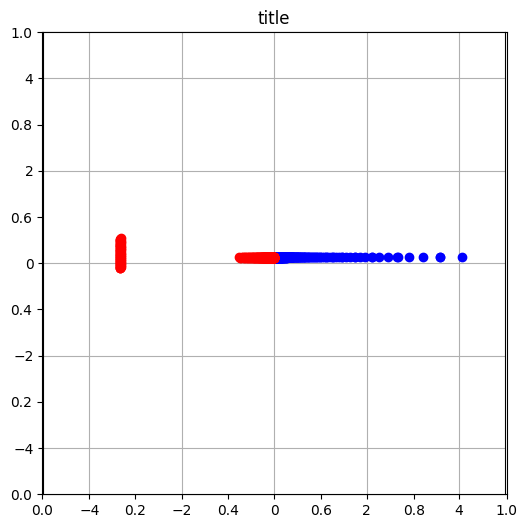

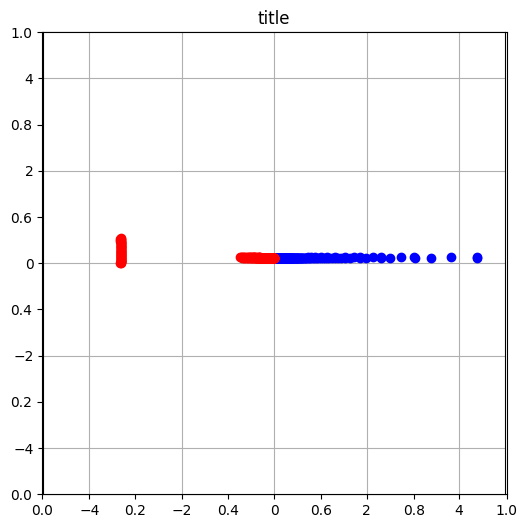

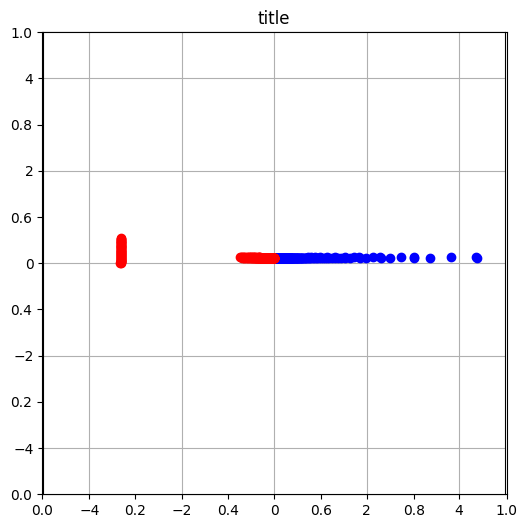

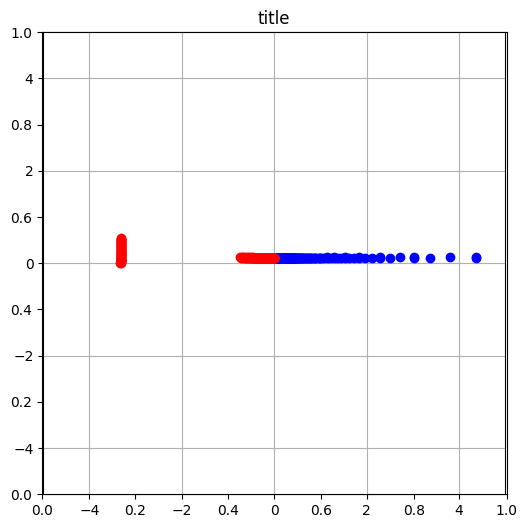

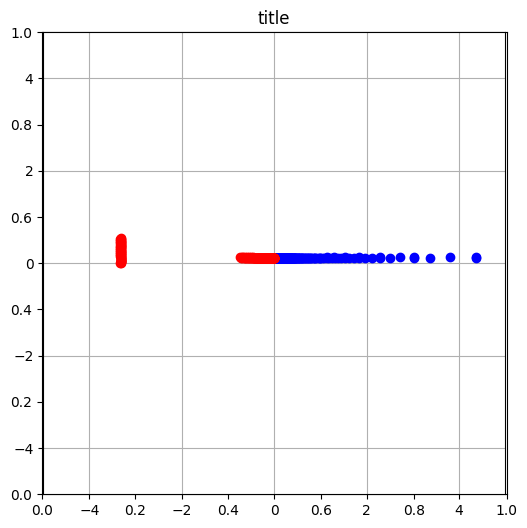

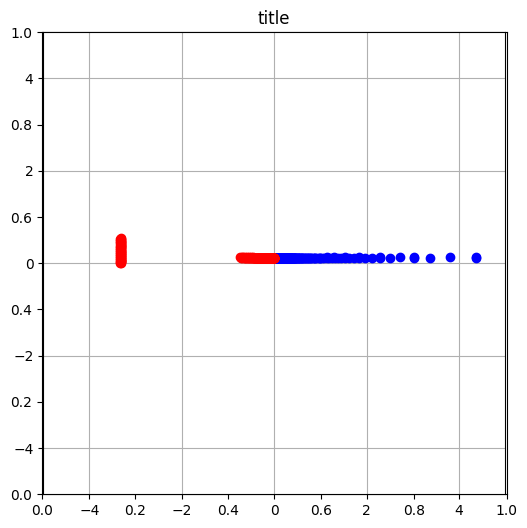

In [40]:
import time

def main():

    #inicializa a simulação
    sim.startSimulation()
    robotname = 'Pioneer_p3dx'
    robotHandle = sim.getObject("/" + robotname)  
    robotLeftMotorHandle = sim.getObject("/" +robotname + '_leftMotor')
    robotRightMotorHandle = sim.getObject("/" + robotname + '_rightMotor')

    x_goal = np.array([-4.74447, +0.100]) #teste 1
    # x_goal = np.array([-7.24447, -7.900]) #teste 2

    L = 0.331
    r = 0.0975
    maxv = 1.0 #LIMITADORES DA VELOCIDADE LINEAR
    maxw = np.deg2rad(45) #LIMITADORES DA VELOCIDADE ANGULAR

    rho = np.inf
    random_force = 0.1
    points_objects = []
    max_sensor_range=5 
    Frep_total = np.array([0.0, 0.0])
    # Loop principal do controle do robô (Controlador De Luca e Oriolo)
    while rho > .05:

        # Definir os identificadores dos objetos do robô
        raw_range_data, raw_angle_data = readSensorData()
        laser_data = np.array([raw_angle_data, raw_range_data]).T
        robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)
        robotPos = robotPos[0:2]
        transformationMatrix_LaserWorld = get_Transformation_matrix_Laser_World() 
        processes_laser_data(transformationMatrix_LaserWorld, robotPos, "title")
        objectHandle_Laser = sim.getObject("/" + "fastHokuyo")
        posLaser = np.array(sim.getObjectPosition(objectHandle_Laser, 
                                        sim.handle_world))
        for i in range(len(laser_data)):
            ang, dist = laser_data[i] #pega os valores de angulo e distância
            if (max_sensor_range - dist) > 0.1:
                obstacle_world_x = dist * np.cos(ang) #meu x
                obstacle_world_y = dist * np.sin(ang) #meu y

                point = np.array([obstacle_world_x,obstacle_world_y,posLaser[2]])
                print("Matriz de transformação = ", transformationMatrix_LaserWorld)
                print("Ponto = ", point)
                point = transformationMatrix_LaserWorld @ point
                points_objects = [point[0], point[1], 0.5]
                Frep = np.array(rep_force(robotPos, points_objects))
            else:
                Frep = 0
            Frep_total = np.array(Frep_total) + np.array(Frep)
        

        # Calcular as forças de atração e repulsão
        Fatt = att_force(robotPos, x_goal)

        # Adicionar uma força aleatória
        random_force_vector = random_force * np.random.rand(2)
        Ft = Fatt + Frep + random_force_vector
        Ft_x = Ft[0]
        Ft_y = Ft[1]
        # print("aqui", Ft)
        # Apenas para interromper o loop
        rho = np.sqrt(Ft_x**2 + Ft_y**2)
        
        # Calcular velocidade linear e angular usando a fórmula De Luca e Oriolo
        kr = 1
        kt = 2
        robotOri = sim.getObjectOrientation(robotHandle, sim.handle_world)        
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])

        v = kr*(Ft_x*np.cos(robotConfig[2]) + Ft_y*np.sin(robotConfig[2]))
        # print("VELOCID", v)
        w = kt*(np.arctan2(Ft_y,Ft_x) - robotConfig[2])
        # print("VELOCID_ W", w)        
        # Limitar v,w aos limites máximos
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw) 

        # Calcular velocidades dos motores
        vr = ((2.0*v) + (w*L))/(2.0*r)
        vl = ((2.0*v) - (w*L))/(2.0*r)
        # print("ARROZ", vr)
        # print("FEIJAO", vl)
        # Definir as velocidades dos motores
        sim.setJointTargetVelocity(robotRightMotorHandle, vr)
        sim.setJointTargetVelocity(robotLeftMotorHandle, vl)
    
    # Parar os motores após o término do loop
    sim.setJointTargetVelocity(robotRightMotorHandle, 0)
    sim.setJointTargetVelocity(robotLeftMotorHandle, 0)
    
    #Plotando os objetos
    time.sleep(2)

    # Para a simulação
    sim.stopSimulation()

main()